### Functional Approach

In [1]:
from tensorflow.keras.layers import Dense, Input
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow import keras
import tensorflow  as tf


# Defining the input Shape
input_layer = Input(shape=(1, )) # Here the input will be a row of columns(can be 10, 100 or 20)

# Output
output_layer = Dense(1)(input_layer)

# Creating the model
model = Model(input_layer, output_layer)

# Compiling the Model
model.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

# Model Summary
model.summary()


ModuleNotFoundError: No module named 'tensorflow'

### Model : 'model_9'

| Layer (type) | Output Shape | Param # |
| ------------------------- | ----------------------------- | ------------------------------ |
| dense_9 (Dense) | (**None**, 1) | 2 |


>#### Dense layers learn a **weight matrix**, where the **first dimension** (**None**, 1) of the matrix is the dimension of the input data, and the **second dimension** (None, **1**) is the dimension of the output data. Recall that your **Input layer has a shape of 1.**
#### In this case, your output layer will also have a shape of 1. This means that the Dense layer will learn a 1x1 weight matrix.

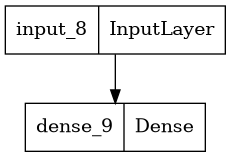

In [85]:
def show_model_diagram(model):
    img = plot_model(model, to_file='model.png')
    return img

# Calling the Function
show_model_diagram(model)

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split

games_tourney_train = pd.read_csv('datasets/basketball_data/games_tourney.csv')
display(games_tourney_train.head())
print(games_tourney_train.shape)

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


(4234, 9)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(games_tourney_train['seed_diff'],
                                                    games_tourney_train['score_diff'],
                                                    test_size=0.2,
                                                    random_state=0)

# Now fit the model
movements = model.fit(X_train, y_train,
                      epochs=10,
                      validation_split=0.001,
                      verbose=True)

Epoch 1/10
106/106 [==============================] - 0s 2ms/step - loss: 10.1267 - accuracy: 0.0109 - val_loss: 8.9922 - val_accuracy: 0.0000e+00
Epoch 2/10
106/106 [==============================] - 0s 1ms/step - loss: 9.9057 - accuracy: 0.0142 - val_loss: 8.9526 - val_accuracy: 0.0000e+00
Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 9.7157 - accuracy: 0.0142 - val_loss: 8.9168 - val_accuracy: 0.0000e+00
Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 9.5652 - accuracy: 0.0142 - val_loss: 8.8846 - val_accuracy: 0.0000e+00
Epoch 5/10
106/106 [==============================] - 0s 1ms/step - loss: 9.4497 - accuracy: 0.0142 - val_loss: 8.8532 - val_accuracy: 0.0000e+00
Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 9.3546 - accuracy: 0.0142 - val_loss: 8.8273 - val_accuracy: 0.0000e+00
Epoch 7/10
106/106 [==============================] - 0s 1ms/step - loss: 9.2812 - accuracy: 0.0142 - val_loss: 8.8066 - va

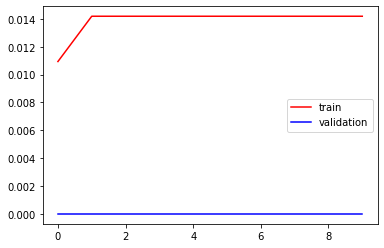

In [88]:
plt.plot(movements.history['accuracy'], color='red', label='train')
plt.plot(movements.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [89]:
# Evaluate the model on the test data
model.evaluate(X_test, y_test, verbose=False)

[9.200105667114258, 0.009445100091397762]

## Category embeddings

#### Shared layers allow a model to use the same weight matrix for multiple steps.

In [90]:
# Imports
from tensorflow.keras.layers import Embedding, Flatten
from numpy import unique

# Reading data 
games_season = pd.read_csv('datasets/basketball_data/games_season.csv')

# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

print(n_teams)

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')




10888


#### We will build a "team strength" layer that represents each team by a single number

In [91]:
# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

## Shared layers/ "siamese networks"

#### Shared layers are an **advanced deep learning concept,** and are only possible with the Keras functional API. *They allow you to define an operation and then apply the exact same operation **(with the exact same weights)** on different inputs.*

In [92]:
# Load the input layer from tensorflow.keras.layers


# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

In [93]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)
print(team_1_strength.is_tensor_like)

True


In [94]:
# Import the Subtract layer from tensorflow.keras
from tensorflow.keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

print(score_diff)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='subtract_1/sub:0', description="created by layer 'subtract_1'")


In [95]:
# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile('adam', 'mean_absolute_error')

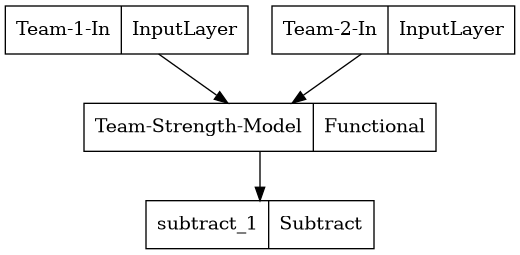

In [96]:
show_model_diagram(model)

In [97]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=5,
          validation_split=0.1,
          verbose=True)

Epoch 1/5
8780/8780 [==============================] - 9s 1ms/step - loss: 12.0493 - val_loss: 11.7257
Epoch 2/5
8780/8780 [==============================] - 9s 1ms/step - loss: 11.8610 - val_loss: 11.5931
Epoch 3/5
8780/8780 [==============================] - 8s 952us/step - loss: 11.6773 - val_loss: 11.4622
Epoch 4/5
8780/8780 [==============================] - 10s 1ms/step - loss: 11.5026 - val_loss: 11.3352
Epoch 5/5
8780/8780 [==============================] - 9s 969us/step - loss: 11.3375 - val_loss: 11.2125


In [98]:
# Get team_1 from the tournament data
input_1 = games_tourney_train['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney_train['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney_train['score_diff'], verbose=False))

11.335820198059082


## Beyond 2 Inputs

In [99]:
from tensorflow.keras.layers import Concatenate

# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [100]:
# Import the model class


# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

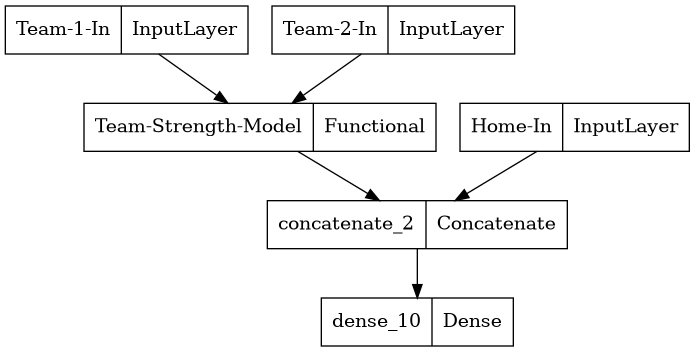

In [101]:
show_model_diagram(model)

In [107]:
# Fit the model to the games_season dataset
movements = model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=0.1)

# Evaluate the model on the games_tourney dataset
model.evaluate([games_season['team_1'], games_season['team_2'], games_season['home']],
                     games_season['score_diff'],
                     verbose=False)

8780/8780 [==============================] - 9s 1ms/step - loss: 8.4033 - accuracy: 0.0154 - val_loss: 8.8763 - val_accuracy: 0.0000e+00


[8.342394828796387, 0.013815836049616337]

In [108]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 Home-In (InputLayer)           [(None, 1)]          0           []                        

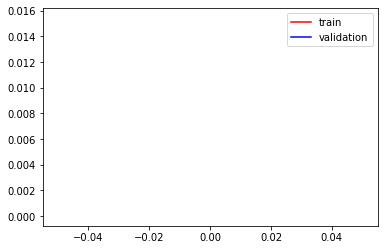

In [110]:
plt.plot(movements.history['accuracy'], color='red', label='train')
plt.plot(movements.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

## Stacking models

#### Stacking keras models means using the predictions from one model as an input to a second model. 

In [111]:
games_tourney = pd.read_csv('datasets/basketball_data/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [112]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'] , games_tourney['home']])
games_tourney.head()

133/133 [==============================] - 0s 737us/step


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,-4.725586
1,1985,5929,73,0,4,6,61,55,1,-1.366482
2,1985,9884,73,0,5,-4,59,63,0,2.513804
3,1985,73,288,0,3,9,50,41,1,-0.071169
4,1985,3920,410,0,1,-9,54,63,0,-0.407283


In [113]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

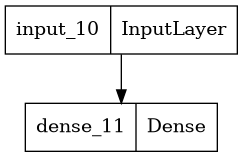

In [114]:
show_model_diagram(model)

In [115]:
# Fit the model
model.fit(games_tourney[['home', 'seed_diff', 'pred']],
          games_tourney['score_diff'],
          epochs=5,
          verbose=True)

Epoch 1/5
133/133 [==============================] - 0s 806us/step - loss: 8.9941
Epoch 2/5
133/133 [==============================] - 0s 965us/step - loss: 8.9467
Epoch 3/5
133/133 [==============================] - 0s 955us/step - loss: 8.9303
Epoch 4/5
133/133 [==============================] - 0s 925us/step - loss: 8.9229
Epoch 5/5
133/133 [==============================] - 0s 1ms/step - loss: 8.9181


In [116]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney[['home', 'seed_diff', 'pred']],
               games_tourney['score_diff'], verbose=False))

8.91511344909668


### Simple two-output model

### Classification and regression in one model

In [117]:
# Create an input layer with 2 columns
input_tensor = Input(shape=(2, ))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

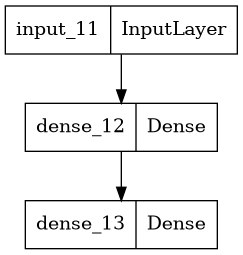

In [121]:
show_model_diagram(model)

In [119]:
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'],optimizer=Adam(learning_rate=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney[['seed_diff', 'pred']],
          [games_tourney[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10
1/1 [==============================] - 0s 340ms/step - loss: 13.7749 - dense_12_loss: 12.3437 - dense_13_loss: 1.4312
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 13.7285 - dense_12_loss: 12.2686 - dense_13_loss: 1.4599
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 13.6860 - dense_12_loss: 12.1968 - dense_13_loss: 1.4892
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 13.6467 - dense_12_loss: 12.1339 - dense_13_loss: 1.5128
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 13.6086 - dense_12_loss: 12.0837 - dense_13_loss: 1.5249
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 13.5707 - dense_12_loss: 12.0453 - dense_13_loss: 1.5254
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 13.5327 - dense_12_loss: 12.0153 - dense_13_loss: 1.5174
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 13.4947 - dense_12_loss: 11.9909 - dens

In [122]:
print(model.get_weights())

[array([[-0.5167884],
       [ 0.5378348]], dtype=float32), array([[-1.241304]], dtype=float32)]


In [124]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = -1.241304

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.22420908722161387
4.06521443335604e-06


In [127]:
# Evaluate the model on new data
print(model.evaluate(games_tourney[['seed_diff', 'pred']],
               [games_tourney[['score_diff']], games_tourney[['won']]], verbose=False))

[13.381877899169922, 11.937427520751953, 1.4444490671157837]
